In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras import models
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

import seaborn as sns
import os, shutil
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

# Import data

In [ ]:
from getpass import getpass
import os

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle competitions download -c copy-of-shai-level-2-training

 99% 523M/526M [00:19<00:00, 19.8MB/s]
100% 526M/526M [00:19<00:00, 28.2MB/s]


In [ ]:
!chmod 777 *

In [ ]:
!unzip copy-of-shai-level-2-training.zip

Archive:  copy-of-shai-level-2-training.zip
  inflating: sample_submission.csv   
  inflating: test/040263.jpeg        
  inflating: test/0621724.jpeg       
  inflating: test/0777738.jpeg       
  inflating: test/10256151.jpeg      
  inflating: test/105615245.jpeg     
  inflating: test/10674923.jpeg      
  inflating: test/10779808.jpeg      
  inflating: test/109152324.jpeg     
  inflating: test/111993936.jpeg     
  inflating: test/11352122.jpeg      
  inflating: test/11545830.jpeg      
  inflating: test/117560797.jpeg     
  inflating: test/118551363.jpeg     
  inflating: test/119145669.jpeg     
  inflating: test/11971304.png       
  inflating: test/120186574.jpeg     
  inflating: test/12119481.png       
  inflating: test/121283966.jpeg     
  inflating: test/123325136.jpeg     
  inflating: test/123789527.jpeg     
  inflating: test/126307058.jpeg     
  inflating: test/126768317.jpg      
  inflating: test/127126503.jpeg     
  inflating: test/127438827.jpeg     
  infl

# Explore Data

In [ ]:
train_data_df=pd.read_csv('/content/train.csv')

In [ ]:
train_data_df.head(10)

,Image,Label
0,597631776.jpeg,normal
1,35266064.jpeg,virus
2,467414642.jpeg,normal
3,35667640.jpeg,normal
4,618841263.jpeg,normal
5,542634377.jpeg,normal
6,100770198.jpeg,virus
7,544944690.jpeg,normal
8,4019678.jpeg,normal
9,366899638.png,covid


In [ ]:
train_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196 entries, 0 to 1195
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   1196 non-null   object
 1   Label   1196 non-null   object
dtypes: object(2)
memory usage: 18.8+ KB


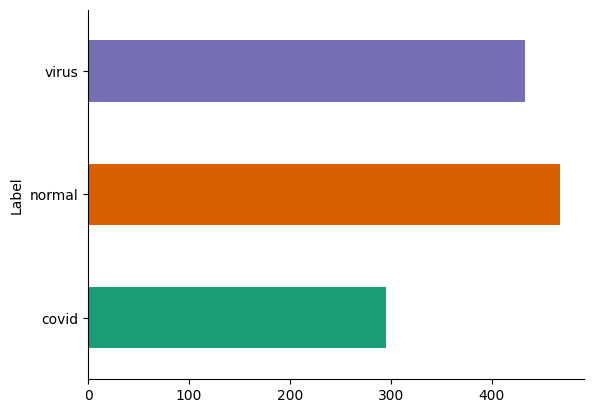

In [ ]:
# @title Label

from matplotlib import pyplot as plt
import seaborn as sns
train_data_df.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

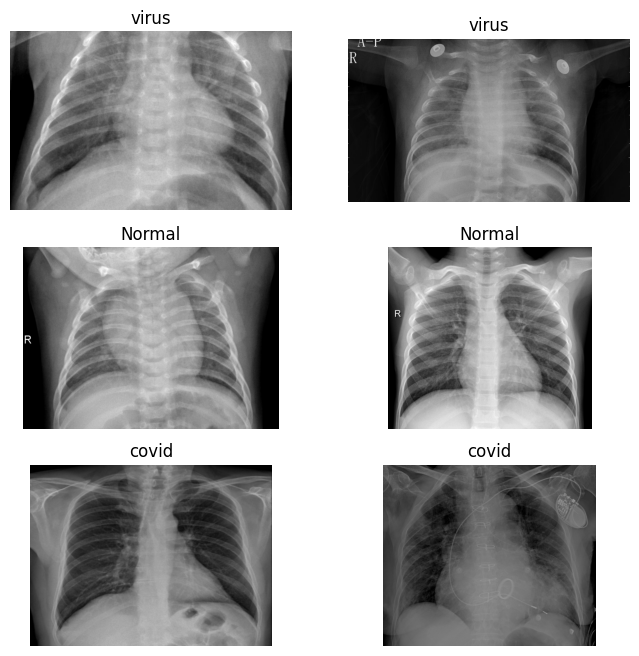

In [ ]:
# Plotting raw images just for review
train_dir='/content/train'

plt.figure(figsize=(8,8))
for i,img_path in enumerate(train_data_df['Image'][train_data_df['Label'] == "virus"][0:2]):
    plt.subplot(3,2,i+1)
    plt.axis('off')
    #print(img_path)
    img = plt.imread(train_dir+ '/virus' +'/'+ img_path)
    plt.imshow(img, cmap='gray')
    plt.title('virus')

for i,img_path in enumerate(train_data_df[train_data_df['Label'] == "normal"][0:2]['Image']):
    plt.subplot(3,2,2+i+1)
    plt.axis('off')
    img = plt.imread(train_dir+'/normal' +'/'+img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')

for i,img_path in enumerate(train_data_df[train_data_df['Label'] == "covid"][0:2]['Image']):
    plt.subplot(3,2,4+i+1)
    plt.axis('off')
    img = plt.imread(train_dir+'/covid'+'/'+img_path)
    plt.imshow(img, cmap='gray')
    plt.title('covid')
   # /content/train/virus/35266064.jpeg

# Processing Data

In [ ]:
# we splite data to train . validation
if not os.path.isdir(r'/content/valid/'):
    os.makedirs(r'/content/valid/')

    for label in os.listdir(r'/content/train/'):
        valid_images=random.sample(os.listdir(r'/content/train/'+label),int(len(os.listdir('/content/train/'+label))*.20))
        for image in valid_images:
            if not os.path.isdir(f'/content/valid/{label}'):
                os.makedirs(f'/content/valid/{label}')
            shutil.move(f'/content/train/{label}/{image}',f'/content/valid/{label}')
        test_images=random.sample(os.listdir(r'/content/valid/'+label),int(len(os.listdir('/content/valid/'+label))*.50))

In [ ]:
train_dir = "/content/train/"
vali_dir = "/content/valid/"
test_dir="/content/"


IMG_HEIGHT= 224
IMG_WIDTH= 224
BATCH_SIZE=32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=(1.2, 1.5),
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

val_data = train_datagen.flow_from_directory(
    vali_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False,
    batch_size=1,
    classes=['test']
)

Found 1196 images belonging to 3 classes.
Found 238 images belonging to 3 classes.
Found 513 images belonging to 1 classes.


# Modeling

Start with CNN

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 128)      

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/30
38/38 [==============================] - 190s 5s/step - loss: 0.9258 - acc: 0.5527 - val_loss: 0.6571 - val_acc: 0.7437
Epoch 2/30
38/38 [==============================] - 179s 5s/step - loss: 0.5216 - acc: 0.8102 - val_loss: 0.3925 - val_acc: 0.8529
Epoch 3/30
38/38 [==============================] - 183s 5s/step - loss: 0.4116 - acc: 0.8445 - val_loss: 0.3193 - val_acc: 0.8908
Epoch 4/30
38/38 [==============================] - 191s 5s/step - loss: 0.3328 - acc: 0.8880 - val_loss: 0.2926 - val_acc: 0.8697
Epoch 5/30
38/38 [==============================] - 184s 5s/step - loss: 0.3223 - acc: 0.8704 - val_loss: 0.2338 - val_acc: 0.9160
Epoch 6/30
38/38 [==============================] - 186s 5s/step - loss: 0.2850 - acc: 0.8963 - val_loss: 0.2597 - val_acc: 0.9160
Epoch 7/30
38/38 [==============================] - 187s 5s/step - loss: 0.2890 - acc: 0.9013 - val_loss: 0.2320 - val_acc: 0.9034
Epoch 8/30
38/38 [==============================] - 184s 5s/step - loss: 0.2762 - a

Text(0.5, 1.0, 'Training-Validation Accuracy')

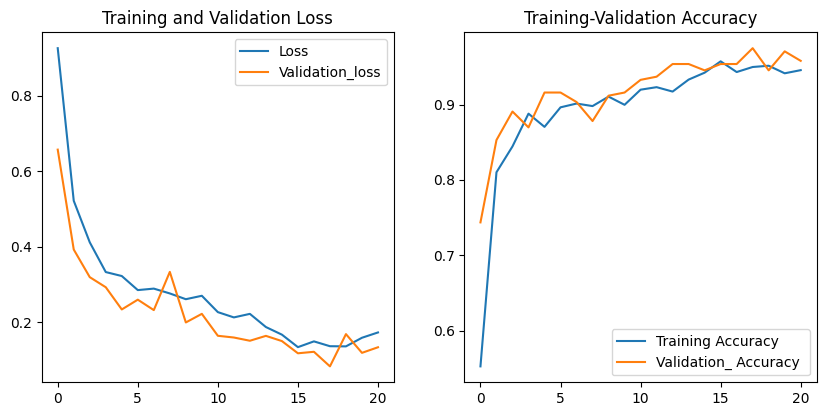

In [ ]:
#saving the model history
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['acc'],label = "Training Accuracy")
plt.plot(loss['val_acc'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

In [ ]:
predictions = model.predict(val_data)

#predictions = np.argmax(predictions, axis = 1)
#y_test_new = np.argmax(val_data.labels, axis = 1)

8/8 [==============================] - 24s 3s/step


In [ ]:
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
val_data.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [ ]:
classes = train_data.class_indices
print(classes)
#pred_lab = predictions.tolist()
#print(pred_lab)
result = map(lambda x: list(classes.keys())[x], predictions)
labels = list(result)

In [ ]:
print(classification_report(val_data.labels, predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        59
           1       0.99      0.95      0.97        93
           2       0.94      0.98      0.96        86

    accuracy                           0.97       238
   macro avg       0.97      0.97      0.97       238
weighted avg       0.97      0.97      0.97       238



**Mobile-net**

In [ ]:
train_data = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_dir, target_size=(IMG_HEIGHT,IMG_WIDTH), batch_size=BATCH_SIZE)

valid_data = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=vali_dir, target_size=(IMG_HEIGHT,IMG_WIDTH), shuffle=False, batch_size=BATCH_SIZE)

test_data = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_dir, target_size=(IMG_HEIGHT,IMG_WIDTH), batch_size=1, shuffle=False,classes=['test'])

Found 1196 images belonging to 3 classes.
Found 0 images belonging to 0 classes.
Found 513 images belonging to 1 classes.


Dataset used for training and test are pre-processed through augmentation methods. This was done to increase the size and quality of the dataset. This process helps in solving problems related to overfitting and enhances the model’s generalization ability during training and prediction of class labels.

In [ ]:

def make_mobilenet_model(image_size, num_classes):

    input_shape = image_size + (3,)

    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights="imagenet")

    # Freeze the base model by making it non trainable
    base_model.trainable = False


    inputs = tf.keras.Input(shape=input_shape)

    # apply data augmentation to the inputs
    #x = data_augmentation(inputs)
    x = base_model(inputs, training=False)

    x= Dense(512, activation='relu')(x)
    x=Dropout(0.5)(x)
    x= Dense(128, activation='relu')(x)
    x=Dropout(0.5)(x)
    x=Dense(64, activation='relu')(x)
    x=Dropout(0.5)(x)
    x=Dense(32, activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)

    #x = Dropout(0.5)(x)

    prediction_layer = Dense(3, activation='softmax')(x)

    outputs = prediction_layer(x)

    model = Model(inputs, outputs)

    return model

In [ ]:
image_size = (224,224)
mobilenet_model = make_mobilenet_model(image_size, num_classes = 3)

# Preview the Model Summary
mobilenet_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 dense (Dense)               (None, 7, 7, 512)         655872    
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 dense_1 (Dense)             (None, 7, 7, 128)         65664     
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0        

In [ ]:
mobilenet_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])
#tf.random.set_seed(42)

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=2, mode='min')
checkpoint = ModelCheckpoint('mobilenet_model.h5', monitor='val_loss', save_best_only=True, verbose=2, mode='min')

history = mobilenet_model.fit_generator(
      train_data,
      steps_per_epoch=len(train_data),
      epochs=30,
      validation_data=valid_data,
      validation_steps=len(valid_data),
      callbacks=[early_stop,checkpoint],
      verbose=2)

Epoch 1/30

Epoch 1: val_loss improved from inf to 1.06137, saving model to mobilenet_model.h5
30/30 - 75s - loss: 1.3813 - accuracy: 0.3841 - val_loss: 1.0614 - val_accuracy: 0.3613 - 75s/epoch - 2s/step
Epoch 2/30

Epoch 2: val_loss improved from 1.06137 to 0.75928, saving model to mobilenet_model.h5
30/30 - 63s - loss: 0.9706 - accuracy: 0.5209 - val_loss: 0.7593 - val_accuracy: 0.5210 - 63s/epoch - 2s/step
Epoch 3/30

Epoch 3: val_loss improved from 0.75928 to 0.52367, saving model to mobilenet_model.h5
30/30 - 69s - loss: 0.7301 - accuracy: 0.6837 - val_loss: 0.5237 - val_accuracy: 0.7311 - 69s/epoch - 2s/step
Epoch 4/30

Epoch 4: val_loss improved from 0.52367 to 0.33227, saving model to mobilenet_model.h5
30/30 - 63s - loss: 0.5541 - accuracy: 0.7641 - val_loss: 0.3323 - val_accuracy: 0.9076 - 63s/epoch - 2s/step
Epoch 5/30

Epoch 5: val_loss improved from 0.33227 to 0.25703, saving model to mobilenet_model.h5
30/30 - 71s - loss: 0.4924 - accuracy: 0.8006 - val_loss: 0.2570 - va

Text(0.5, 1.0, 'Training-Validation Accuracy')

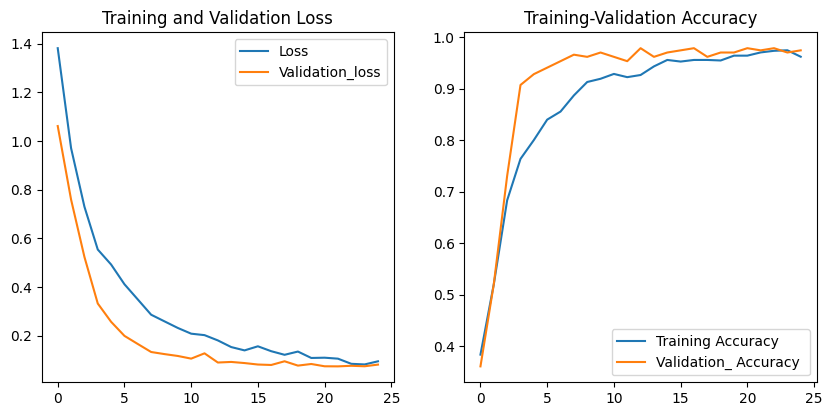

In [ ]:
#saving the model history
loss = pd.DataFrame(mobilenet_model.history.history)

#plotting the loss and accuracy
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label = "Training Accuracy")
plt.plot(loss['val_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

In [ ]:
base_mobilenet_model = mobilenet_model.layers[2] # MobileNetV2 Architecture
base_mobilenet_model.trainable = True

#print(base_mobilenet_model)
# The MobileNet Model has 155 layers (the prediction layer inclusive)
# Fine-tune from this layer onwards
fine_tune_at = 130
base_learning_rate=0.001
# Freeze all the layers before the `fine_tune_at` layer
for layer in mobilenet_model.layers[:fine_tune_at]:
    layer.trainable = True


optimizer = Adam(learning_rate = 0.01 * base_learning_rate)
batch_size = 32
loss = 'categorical_crossentropy'
metrics = ['accuracy']
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('mobilenet_model.h5', monitor='val_loss', save_best_only=True, verbose=2, mode='min')


mobilenet_model.compile(optimizer = optimizer,
                        loss = loss,
                        metrics = metrics)

In [ ]:
fine_tune_epochs = 6
total_epochs =  30 + fine_tune_epochs


history = mobilenet_model.fit_generator(
      train_data,
      steps_per_epoch=len(train_data),
      epochs=total_epochs,
      initial_epoch = 25,
      validation_data=valid_data,
      validation_steps=len(valid_data),
      callbacks=[early_stop,checkpoint],
      verbose=1)

Epoch 26/36
30/30 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9979
Epoch 26: val_loss improved from inf to 0.02760, saving model to mobilenet_model.h5
30/30 [==============================] - 167s 5s/step - loss: 0.0046 - accuracy: 0.9979 - val_loss: 0.0276 - val_accuracy: 0.9916
Epoch 27/36
30/30 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.9969
Epoch 27: val_loss did not improve from 0.02760
30/30 [==============================] - 143s 5s/step - loss: 0.0074 - accuracy: 0.9969 - val_loss: 0.1407 - val_accuracy: 0.9664
Epoch 28/36
30/30 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9979
Epoch 28: val_loss did not improve from 0.02760
30/30 [==============================] - 142s 5s/step - loss: 0.0148 - accuracy: 0.9979 - val_loss: 0.0641 - val_accuracy: 0.9790
Epoch 29/36
30/30 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9990
Epoch 29: val_loss did not improve from 0.02760
30

Text(0.5, 1.0, 'Training-Validation Accuracy')

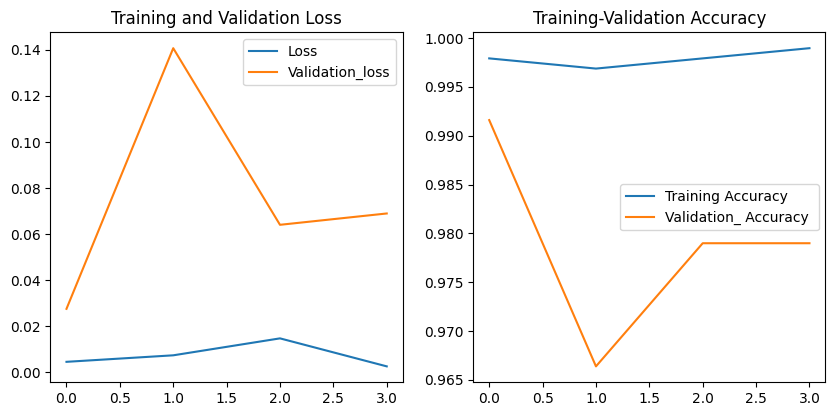

In [ ]:
#saving the model history
loss = pd.DataFrame(mobilenet_model.history.history)

#plotting the loss and accuracy
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label = "Training Accuracy")
plt.plot(loss['val_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

In [ ]:
image_size = (224,224)
#mobilenet_model = make_mobilenet_model(image_size, num_classes = 3)

In [ ]:
from tensorflow.keras.models import load_model


mobilenet_model = load_model('/content/mobilenet_model.h5')

In [ ]:
#predictions = mobilenet_model.predict(x=valid_data)

In [ ]:
#predictions = mobilenet_model.predict(valid_data)

#y_pred = np.argmax(predictions, axis = 1)

In [ ]:
#print(classification_report(valid_data.labels, y_pred))

In [ ]:
predictions2 = mobilenet_model.predict(x=test_data, steps=len(test_data), verbose=0)

In [ ]:
predictions2 = np.argmax(predictions2, axis=1)
print(predictions2)


[0 2 0 2 2 2 0 0 2 2 1 2 1 1 0 2 0 1 1 0 2 0 0 2 1 2 2 0 2 1 2 0 2 1 2 0 2
 0 0 2 0 1 0 0 2 1 0 1 2 0 2 2 0 0 2 2 0 1 2 1 0 0 0 1 2 2 2 2 2 1 2 0 0 0
 0 2 0 1 0 0 1 0 1 0 0 2 2 1 1 2 1 0 1 1 2 2 1 0 2 1 1 0 0 1 1 0 0 1 1 0 2
 0 1 2 0 2 1 0 2 1 1 2 1 1 2 1 2 0 2 0 2 0 1 1 0 1 1 2 1 1 2 2 2 1 2 0 0 1
 2 2 0 1 2 2 0 0 2 1 0 2 1 0 1 0 2 0 0 1 2 2 1 1 0 2 0 0 2 0 2 0 1 2 1 2 1
 0 0 0 1 2 1 2 0 0 0 2 1 1 1 1 2 2 1 2 1 1 2 2 0 1 2 1 1 2 1 2 1 1 2 0 1 1
 2 2 0 2 0 1 2 1 2 0 1 0 1 0 2 2 1 0 2 0 2 1 0 2 0 0 0 2 0 2 1 2 2 2 0 0 1
 2 2 1 2 0 2 2 2 0 2 0 2 1 0 0 2 1 2 1 0 2 0 2 1 2 0 1 2 0 2 0 0 1 2 0 0 2
 1 1 1 1 1 2 0 1 1 0 0 0 2 0 1 2 1 0 1 2 1 1 2 1 0 1 1 0 2 1 2 1 2 2 2 1 0
 2 1 2 2 1 1 2 1 2 0 1 1 1 1 1 1 2 1 1 2 2 1 2 1 1 1 2 2 1 1 1 2 1 2 2 1 2
 0 2 1 2 2 2 2 1 1 1 2 1 2 0 1 2 1 2 1 1 2 1 2 1 1 2 2 2 2 2 1 1 2 2 0 2 1
 2 0 2 2 2 1 1 1 0 2 2 1 1 2 2 1 0 2 1 1 2 2 2 1 2 1 2 2 1 2 0 1 2 1 2 2 1
 2 2 1 2 1 2 2 1 2 0 2 2 2 2 2 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 2 1 0 2
 1 2 0 0 2 0 2 0 2 1 1 2 

In [ ]:
#result = map(lambda x: list (class_names[x]), predictions)

In [ ]:
df=pd.DataFrame()
df["Image"] = list(map(lambda x: x[5:], test_data.filenames))
df.head()

,Image
0,040263.jpeg
1,0621724.jpeg
2,0777738.jpeg
3,10256151.jpeg
4,105615245.jpeg


In [ ]:
classes = train_data.class_indices
print(classes)
#pred_lab = predictions.tolist()
#print(pred_lab)
result = map(lambda x: list(classes.keys())[x], predictions2)
labels = list(result)
df['Label'] = labels
print(df.head())
df.to_csv('mobilenet-v2-97-25-fine-tune.csv', index=False)

{'covid': 0, 'normal': 1, 'virus': 2}
            Image  Label
0     040263.jpeg  covid
1    0621724.jpeg  virus
2    0777738.jpeg  covid
3   10256151.jpeg  virus
4  105615245.jpeg  virus
